In [ ]:
import torch
if torch.cuda.is_available():
    print("GPU is available!")
    print("Device Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available.")

GPU is available!
Device Name: Tesla T4


2025-06-23 23:22:40.363593: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750738960.398998   34074 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750738960.412597   34074 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750738960.446225   34074 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750738960.446257   34074 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750738960.446262   34074 computation_placer.cc:177] computation placer alr

Instructions for updating:
non-resource variables are not supported in the long term


2025-06-23 23:22:45.378685: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


--- Starting Adam optimization ---
Compiling model...
Building feed-forward neural network...
'build' took 0.091564 s

'compile' took 0.758661 s

Training model...



I0000 00:00:1750738966.644335   34074 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled


Step      Train loss              Test loss               Test metric   
0         [3.25e+01, 2.76e-01]    [4.11e+01, 2.76e-01]    [1.65e+00]    
1000      [4.20e-03, 1.02e-02]    [3.50e-03, 1.02e-02]    [1.99e-01]    
2000      [7.37e-04, 1.27e-03]    [6.24e-04, 1.27e-03]    [6.79e-02]    
3000      [2.78e-04, 4.93e-04]    [2.65e-04, 4.93e-04]    [4.18e-02]    
4000      [3.30e-04, 2.72e-04]    [3.61e-04, 2.72e-04]    [3.09e-02]    
5000      [1.84e-04, 1.73e-04]    [2.10e-04, 1.73e-04]    [2.45e-02]    
6000      [6.17e-04, 1.27e-04]    [6.99e-04, 1.27e-04]    [2.08e-02]    
7000      [3.47e-04, 1.09e-04]    [3.06e-04, 1.09e-04]    [2.01e-02]    
8000      [7.44e-05, 7.90e-05]    [8.27e-05, 7.90e-05]    [1.64e-02]    
9000      [3.63e-04, 7.08e-05]    [3.98e-04, 7.08e-05]    [1.62e-02]    
10000     [8.51e-04, 6.36e-05]    [8.84e-04, 6.36e-05]    [1.49e-02]    
11000     [1.40e-04, 5.31e-05]    [1.27e-04, 5.31e-05]    [1.37e-02]    
12000     [1.55e-03, 7.77e-05]    [1.39e-03, 7.77e-

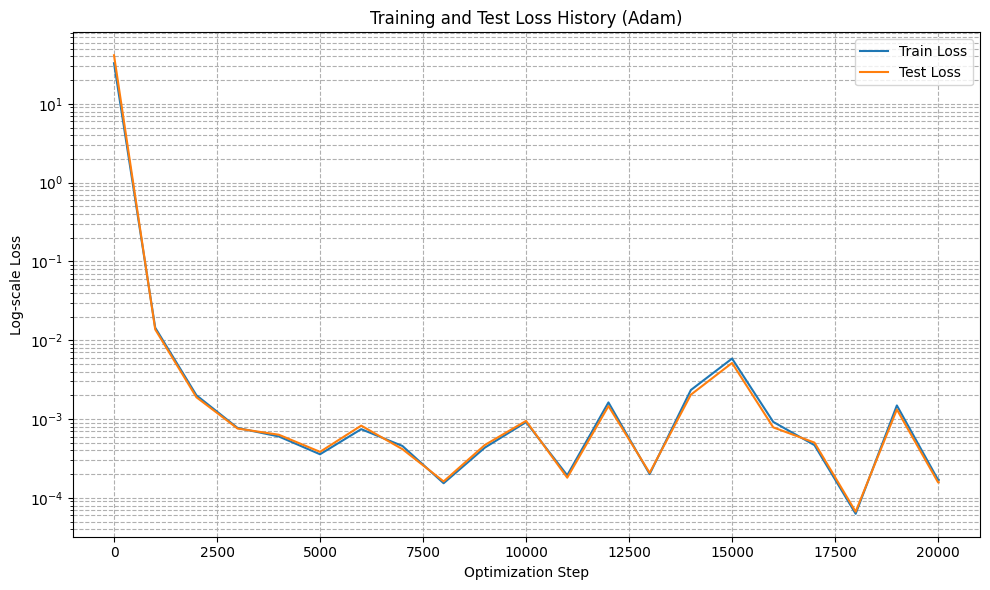


--- Generating Final Solution Plots ---


2025-06-23 23:53:44.484612: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37400000 exceeds 10% of free system memory.
2025-06-23 23:53:44.515705: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37400000 exceeds 10% of free system memory.
2025-06-23 23:53:44.552893: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37400000 exceeds 10% of free system memory.
2025-06-23 23:53:44.587891: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37400000 exceeds 10% of free system memory.


Solution comparison plot saved to poisson_l_shape_solution.png


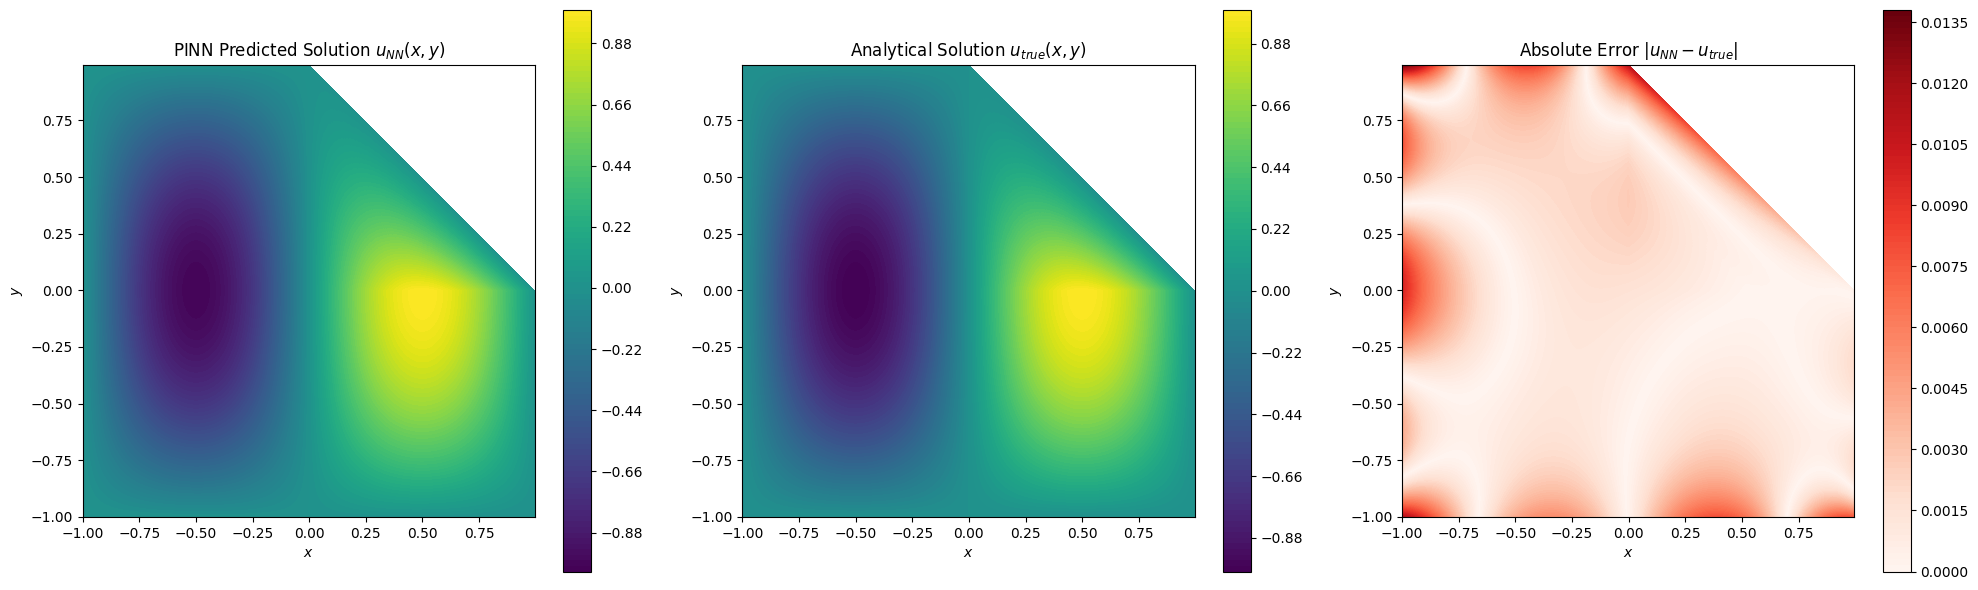


Final L2 relative error on plot points: 4.7810e-03


In [1]:
"""
Solves the Poisson equation on an L-shaped domain using DeepXDE.

This script trains a Physics-Informed Neural Network (PINN) and visualizes
both the training loss history and the final solution comparison.
"""

import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import deepxde as dde
import os

# Set the backend to PyTorch for consistency.
os.environ['DDE_BACKEND'] = 'pytorch'
dde.config.set_random_seed(42)

# --- 1. Define the Problem: Geometry, PDE, and Boundary Conditions ---

# Define the L-shaped domain using the vertices of a polygon.
# The domain is the square [-1, 1] x [-1, 1] with the quadrant [0, 1] x [-1, 0] removed.
# The re-entrant corner at (0, 0) introduces a singularity, a classic challenge.
vertices = [[-1, -1], [1, -1], [1, 0], [0, 0], [0, 1], [-1, 1]]
geom = dde.geometry.Polygon(vertices)

# Define the Poisson equation.
# The forcing function f(x, y) is derived from a known analytical solution
# to allow for rigorous validation of the network's accuracy.
def pde(x, u):
    """
    Defines the residual of the Poisson equation: ∇²u - f = 0.

    Args:
        x: A tensor of coordinates (x, y) with shape [N, 2].
        u: The network's output tensor u(x, y) with shape [N, 1].

    Returns:
        The PDE residual tensor.
    """
    # The Laplacian is computed by summing the second partial derivatives.
    # dde.grad.hessian(u, x, i=0, j=0) computes ∂²u/∂x²
    # dde.grad.hessian(u, x, i=1, j=1) computes ∂²u/∂y²
    dudx2 = dde.grad.hessian(u, x, i=0, j=0)
    dudy2 = dde.grad.hessian(u, x, i=1, j=1)
    laplacian = dudx2 + dudy2

    x_ = x[:, 0:1]
    y_ = x[:, 1:2]

    # Forcing function: f(x, y) = - (5/4)π² * sin(πx) * cos(πy / 2)
    pi = np.pi
    forcing_term = -(5.0 / 4.0) * pi**2 * dde.backend.sin(pi * x_) * dde.backend.cos(pi * y_ / 2.0)

    return laplacian - forcing_term

# Define the analytical solution used for validation and boundary conditions.
def analytical_solution(x):
    """
    Analytical solution u(x, y) = sin(πx) * cos(πy / 2).

    Args:
        x: A NumPy array of coordinates with shape [N, 2].

    Returns:
        The solution u at each coordinate.
    """
    x_, y_ = x[:, 0:1], x[:, 1:2]
    return np.sin(np.pi * x_) * np.cos(np.pi * y_ / 2.0)

# The boundary condition function simply returns the analytical solution on the boundary.
def boundary_func(x):
    """
    Computes the boundary values from the analytical solution.
    This handles the non-homogeneous part of the Dirichlet condition.
    """
    return analytical_solution(x)

# Create the Dirichlet Boundary Condition object.
# The lambda function `lambda _, on_boundary: on_boundary` applies this condition
# to all points identified by deepxde as being on the boundary of the geometry.
bc = dde.DirichletBC(geom, boundary_func, lambda _, on_boundary: on_boundary)


# --- 2. Create the Model and Data ---

# Create the PDE data object.
data = dde.data.PDE(
    geom,
    pde,
    bc,
    num_domain=2500,        # Collocation points for enforcing the PDE
    num_boundary=800,       # Collocation points for enforcing the BC
    solution=analytical_solution,
    num_test=1000,          # Points for calculating validation error during training
)

# Define the neural network architecture.
# Input: 2 neurons (x, y)
# Hidden Layers: 4 layers with 50 neurons each, using the 'tanh' activation function.
# Output: 1 neuron (u)
net = dde.nn.FNN([2] + [50] * 4 + [1], "tanh", "Glorot normal")

# Create the deepxde model.
model = dde.Model(data, net)


# --- 3. Train the Model ---

# Stage 1: Adam optimizer for initial training.
print("--- Starting Adam optimization ---")
model.compile("adam", lr=1e-3, metrics=["l2 relative error"])
# We capture the returned history object to plot the loss evolution.
adam_losshistory, train_state = model.train(iterations=20000)

# Stage 2: L-BFGS optimizer for fine-tuning.
# This second-order optimizer is often used after Adam to achieve higher accuracy.
print("\n--- Starting L-BFGS optimization ---")
model.compile("L-BFGS")
lbfgs_losshistory, train_state = model.train()


# --- 4. Visualize Training History ---
print("\n--- Generating Loss History Plot ---")

# Extract loss data from the Adam training history
loss_train = np.sum(adam_losshistory.loss_train, axis=1)
loss_test = np.sum(adam_losshistory.loss_test, axis=1)
steps = adam_losshistory.steps

# Create and save the loss plot
plt.figure(figsize=(10, 6))
plt.plot(steps, loss_train, label='Train Loss')
plt.plot(steps, loss_test, label='Test Loss')
plt.yscale('log')
plt.title('Training and Test Loss History (Adam)')
plt.xlabel('Optimization Step')
plt.ylabel('Log-scale Loss')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.savefig("loss_history.png")
print("Loss history plot saved to loss_history.png")
plt.show()


# --- 5. Visualize the Final Results ---
print("\n--- Generating Final Solution Plots ---")

# Generate a dense grid of points for plotting the solution contours.
n_points = 500
x_range = np.linspace(-1, 1, n_points)
y_range = np.linspace(-1, 1, n_points)
grid_x, grid_y = np.meshgrid(x_range, y_range)
plot_points = np.hstack((grid_x.flatten()[:, None], grid_y.flatten()[:, None]))
is_inside = geom.inside(plot_points)
plot_points_inside = plot_points[is_inside]

# Make predictions on the plot points.
u_pred = model.predict(plot_points_inside)
# Calculate the true solution and the point-wise error.
u_true = analytical_solution(plot_points_inside)
error = np.abs(u_pred - u_true)

# Create a triangulation for the unstructured data for contour plotting.
triang = tri.Triangulation(plot_points_inside[:, 0], plot_points_inside[:, 1])

# Create a figure with three subplots for comparison.
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: Predicted Solution
contour1 = axes[0].tricontourf(triang, u_pred.flatten(), levels=100, cmap='viridis')
fig.colorbar(contour1, ax=axes[0])
axes[0].set_title('PINN Predicted Solution $u_{NN}(x,y)$')
axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$y$')
axes[0].set_aspect('equal', 'box')

# Plot 2: Analytical Solution
contour2 = axes[1].tricontourf(triang, u_true.flatten(), levels=100, cmap='viridis')
fig.colorbar(contour2, ax=axes[1])
axes[1].set_title('Analytical Solution $u_{true}(x,y)$')
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('$y$')
axes[1].set_aspect('equal', 'box')

# Plot 3: Absolute Error
contour3 = axes[2].tricontourf(triang, error.flatten(), levels=100, cmap='Reds')
fig.colorbar(contour3, ax=axes[2])
axes[2].set_title('Absolute Error $|u_{NN} - u_{true}|$')
axes[2].set_xlabel('$x$')
axes[2].set_ylabel('$y$')
axes[2].set_aspect('equal', 'box')

plt.tight_layout()
plt.savefig("poisson_l_shape_solution.png")
print("Solution comparison plot saved to poisson_l_shape_solution.png")
plt.show()

# Finally, print the L2 relative error on the test data.
final_error = dde.metrics.l2_relative_error(u_true, u_pred)
print(f"\nFinal L2 relative error on plot points: {final_error:.4e}")
